<a href="https://colab.research.google.com/github/Jennyc08/Telecomx_latam_2_parte_Final/blob/main/Telecom_parteII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import pandas as pd
from pandas import json_normalize

URL = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"
df_raw = pd.read_json(URL)
df = json_normalize(df_raw.to_dict(orient="records"), sep="__")
print("Datos cargados, tamaño:", df.shape)


Datos cargados, tamaño: (7267, 21)


In [32]:
import numpy as np
import pandas as pd

dfc = df.copy()

# --- 1) Normalizar strings (en minúsculas, sin espacios) ---
for c in dfc.columns:
    if dfc[c].dtype == "object":
        dfc[c] = dfc[c].astype("string").str.strip().str.lower()

# --- 2) Mapear Sí/No → 1/0 SOLO si la columna realmente es binaria ---
yn_map = {"sí":1,"si":1,"yes":1,"true":1,"y":1,"1":1, "no":0,"false":0,"n":0,"0":0}
for c in dfc.select_dtypes(include=["string","object"]).columns:
    s = dfc[c].astype("string")
    mapped = s.map(yn_map)
    # si ≥80% de los valores mapean a 0/1, la tratamos como binaria
    if mapped.notna().mean() >= 0.8:
        dfc[c] = mapped.astype("Int8")
    else:
        dfc[c] = s  # se mantiene como texto normal

# --- 3) Intentar numérico o fecha en columnas de texto restantes ---
for c in dfc.select_dtypes(include=["string","object"]).columns:
    s = dfc[c].astype("string")

    # 3a) numérico (permitiendo comas decimales)
    num = pd.to_numeric(s.str.replace(",", ".", regex=False), errors="coerce")
    if num.notna().mean() >= 0.8:
        dfc[c] = num
        continue

    # 3b) fecha
    dt = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
    if dt.notna().mean() >= 0.8:
        dfc[c] = dt.dt.normalize()

# --- 4) Imputación simple + deduplicación ---
for c in dfc.select_dtypes(include=[np.number]).columns:
    if dfc[c].isna().any():
        dfc[c] = dfc[c].fillna(dfc[c].median())

for c in dfc.select_dtypes(include=["string","object","category"]).columns:
    if dfc[c].isna().any():
        moda = dfc[c].mode(dropna=True)
        if not moda.empty:
            dfc[c] = dfc[c].fillna(moda.iloc[0])

dfc = dfc.drop_duplicates().reset_index(drop=True)

print("Limpieza OK. Shape:", dfc.shape)


/tmp/ipython-input-1199235946.py:33: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
/tmp/ipython-input-1199235946.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
/tmp/ipython-input-1199235946.py:33: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(s, errors="coerce

Limpieza OK. Shape: (7267, 21)


In [33]:
dfc.to_csv("datos_telecom_limpios.csv", index=False)
print("Guardado:", "datos_telecom_limpios.csv")

dfc = pd.read_csv("datos_telecom_limpios.csv")
print("Cargado:", dfc.shape)


Guardado: datos_telecom_limpios.csv
Cargado: (7267, 21)


In [34]:
# Lista de columnas a eliminar
cols_a_eliminar = ["customerID", "id_cliente", "numero_cuenta"]

# Filtrar solo las columnas que realmente existen en el DataFrame
cols_a_eliminar = [col for col in cols_a_eliminar if col in dfc.columns]

# Eliminar columnas irrelevantes
dfc = dfc.drop(columns=cols_a_eliminar)

print(f"Columnas eliminadas: {cols_a_eliminar}")
print("Shape final:", dfc.shape)


Columnas eliminadas: ['customerID']
Shape final: (7267, 20)


In [35]:
import pandas as pd

# Identificar variables categóricas
cat_cols = dfc.select_dtypes(include=["object", "category"]).columns

# Aplicar one-hot encoding
dfc_encoded = pd.get_dummies(dfc, columns=cat_cols, drop_first=True)

print(f"DataFrame original: {dfc.shape}")
print(f"DataFrame codificado: {dfc_encoded.shape}")
dfc_encoded.head()


DataFrame original: (7267, 20)
DataFrame codificado: (7267, 30)


,Churn,customer__SeniorCitizen,customer__Partner,customer__Dependents,customer__tenure,phone__PhoneService,phone__MultipleLines,account__PaperlessBilling,account__Charges__Monthly,account__Charges__Total,...,internet__TechSupport_yes,internet__StreamingTV_no internet service,internet__StreamingTV_yes,internet__StreamingMovies_no internet service,internet__StreamingMovies_yes,account__Contract_one year,account__Contract_two year,account__PaymentMethod_credit card (automatic),account__PaymentMethod_electronic check,account__PaymentMethod_mailed check
0,0,0,1,1,9,1,0,1,65.6,593.30,...,True,False,True,False,False,True,False,False,False,True
1,0,0,0,0,9,1,1,0,59.9,542.40,...,False,False,False,False,True,False,False,False,False,True
2,1,0,0,0,4,1,0,1,73.9,280.85,...,False,False,False,False,False,False,False,False,True,False
3,1,1,1,0,13,1,0,1,98.0,1237.85,...,False,False,True,False,True,False,False,False,True,False
4,1,1,1,0,3,1,0,1,83.9,267.40,...,True,False,True,False,False,False,False,False,False,True


Conteo de clases:
 Churn
0    5398
1    1869
Name: count, dtype: int64

Proporción de clases (%):
 Churn
0    74.280996
1    25.719004
Name: proportion, dtype: float64


/tmp/ipython-input-1870798368.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_counts.index, y=churn_counts.values, palette="viridis")


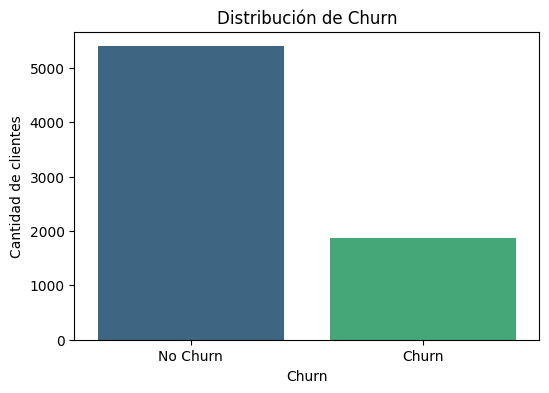

In [36]:
# Conteo de clientes por clase (0 = No Churn, 1 = Churn)
churn_counts = dfc["Churn"].value_counts()

# Proporción en porcentaje
churn_percent = dfc["Churn"].value_counts(normalize=True) * 100

# Mostrar resultados
print("Conteo de clases:\n", churn_counts)
print("\nProporción de clases (%):\n", churn_percent)

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.barplot(x=churn_counts.index, y=churn_counts.values, palette="viridis")
plt.xticks([0, 1], ["No Churn", "Churn"])
plt.ylabel("Cantidad de clientes")
plt.title("Distribución de Churn")
plt.show()


In [37]:
from imblearn.over_sampling import SMOTE
from collections import Counter
import pandas as pd

# Separar variables y target
X = dfc.drop("Churn", axis=1)
y = dfc["Churn"]

# 1️⃣ Codificar variables categóricas a numéricas
X_encoded = pd.get_dummies(X, drop_first=True)

# 2️⃣ Confirmar que ahora todo es numérico
print(X_encoded.dtypes)

# 3️⃣ Aplicar SMOTE
oversampler = SMOTE(random_state=42)
X_over, y_over = oversampler.fit_resample(X_encoded, y)

print("Distribución original:", Counter(y))
print("Distribución tras oversampling:", Counter(y_over))


customer__SeniorCitizen                             int64
customer__Partner                                   int64
customer__Dependents                                int64
customer__tenure                                    int64
phone__PhoneService                                 int64
phone__MultipleLines                                int64
account__PaperlessBilling                           int64
account__Charges__Monthly                         float64
account__Charges__Total                           float64
customer__gender_male                                bool
internet__InternetService_fiber optic                bool
internet__InternetService_no                         bool
internet__OnlineSecurity_no internet service         bool
internet__OnlineSecurity_yes                         bool
internet__OnlineBackup_no internet service           bool
internet__OnlineBackup_yes                           bool
internet__DeviceProtection_no internet service       bool
internet__Devi

In [38]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Escalado estandar (media=0, std=1)
scaler_std = StandardScaler()
X_scaled_std = scaler_std.fit_transform(X_over)

# Escalado Min-Max (0 a 1)
scaler_mm = MinMaxScaler()
X_scaled_mm = scaler_mm.fit_transform(X_over)


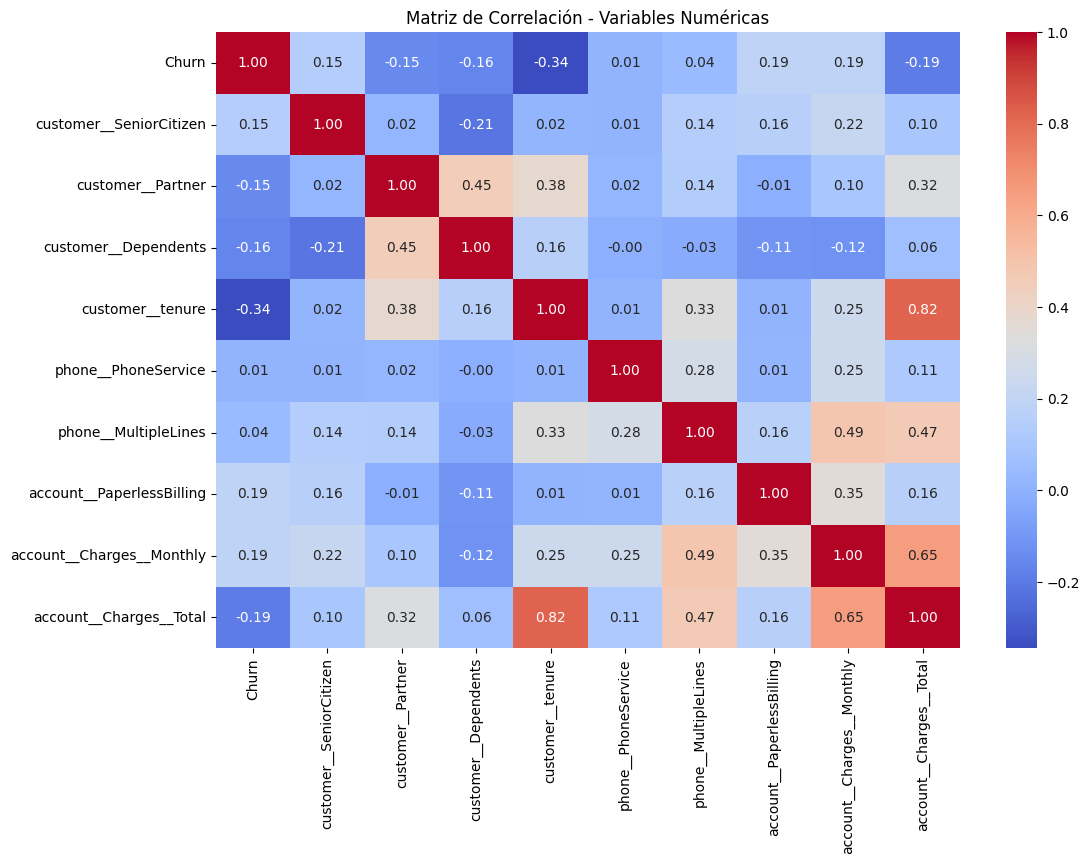

Correlación de cada variable con Churn:
 Churn                        1.000000
account__Charges__Monthly    0.189866
account__PaperlessBilling    0.186666
customer__SeniorCitizen      0.146733
phone__MultipleLines         0.039343
phone__PhoneService          0.012571
customer__Partner           -0.148546
customer__Dependents        -0.161384
account__Charges__Total     -0.194016
customer__tenure            -0.344079
Name: Churn, dtype: float64


In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular matriz de correlación solo con columnas numéricas
corr_matrix = dfc.select_dtypes(include='number').corr()

# Mostrar la matriz completa
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de Correlación - Variables Numéricas")
plt.show()

# Correlaciones ordenadas con respecto a Churn
correlaciones_churn = corr_matrix["Churn"].sort_values(ascending=False)
print("Correlación de cada variable con Churn:\n", correlaciones_churn)


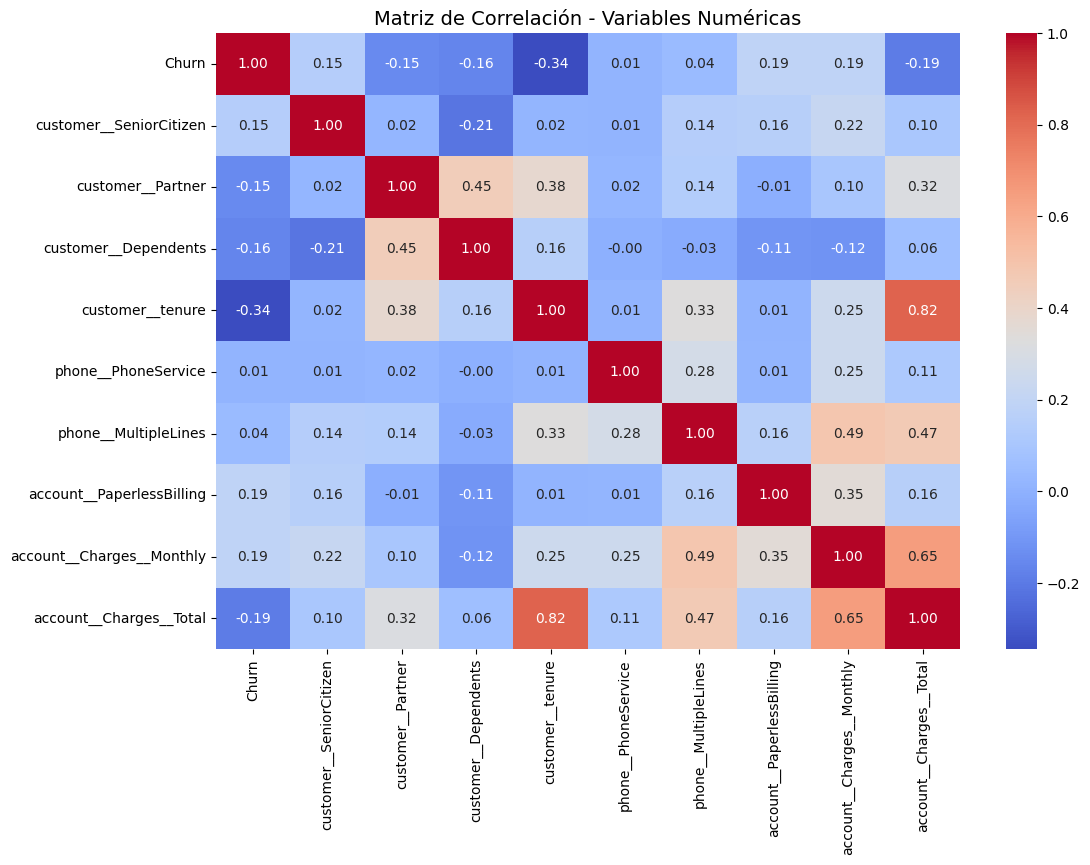

Correlación de cada variable con Churn:
 Churn                        1.000000
account__Charges__Monthly    0.189866
account__PaperlessBilling    0.186666
customer__SeniorCitizen      0.146733
phone__MultipleLines         0.039343
phone__PhoneService          0.012571
customer__Partner           -0.148546
customer__Dependents        -0.161384
account__Charges__Total     -0.194016
customer__tenure            -0.344079
Name: Churn, dtype: float64


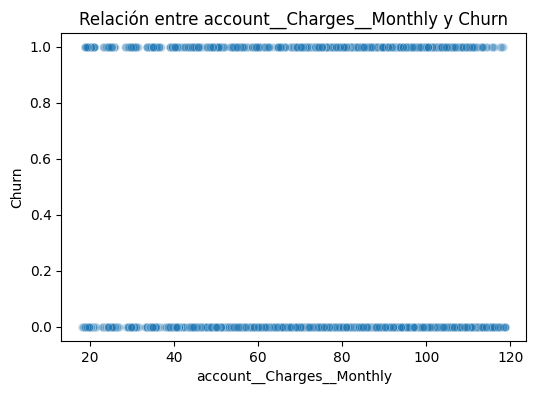

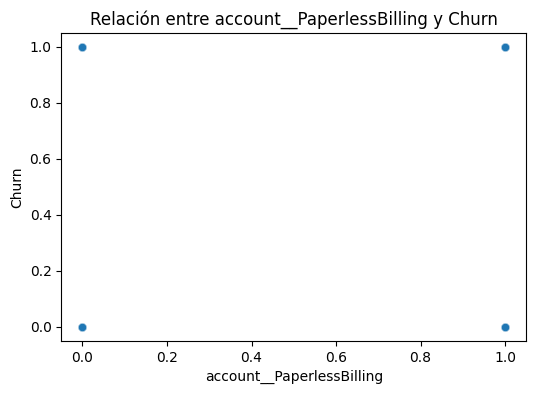

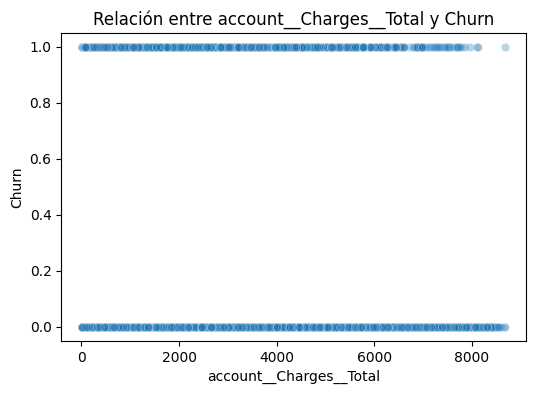

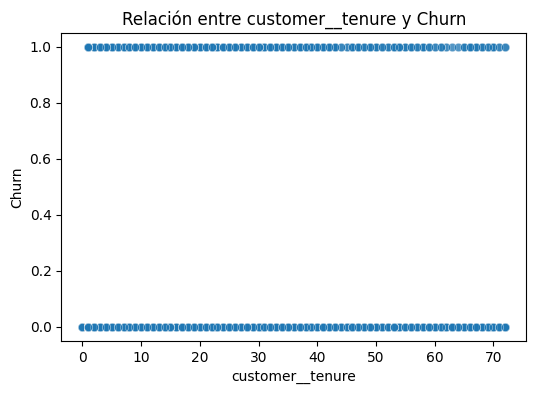

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Matriz de correlación
corr_matrix = dfc.select_dtypes(include='number').corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de Correlación - Variables Numéricas", fontsize=14)
plt.show()

# 2. Correlaciones con Churn
correlaciones_churn = corr_matrix["Churn"].sort_values(ascending=False)
print("Correlación de cada variable con Churn:\n", correlaciones_churn)

# 3. Top variables más correlacionadas (positivas y negativas)
top_vars = list(correlaciones_churn[1:3].index) + list(correlaciones_churn[-2:].index)

# 4. Gráficos de dispersión para esas variables
for var in top_vars:
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=dfc, x=var, y="Churn", alpha=0.3)
    plt.title(f"Relación entre {var} y Churn", fontsize=12)
    plt.show()


In [41]:
print(dfc.columns)


Index(['Churn', 'customer__gender', 'customer__SeniorCitizen',
       'customer__Partner', 'customer__Dependents', 'customer__tenure',
       'phone__PhoneService', 'phone__MultipleLines',
       'internet__InternetService', 'internet__OnlineSecurity',
       'internet__OnlineBackup', 'internet__DeviceProtection',
       'internet__TechSupport', 'internet__StreamingTV',
       'internet__StreamingMovies', 'account__Contract',
       'account__PaperlessBilling', 'account__PaymentMethod',
       'account__Charges__Monthly', 'account__Charges__Total'],
      dtype='object')


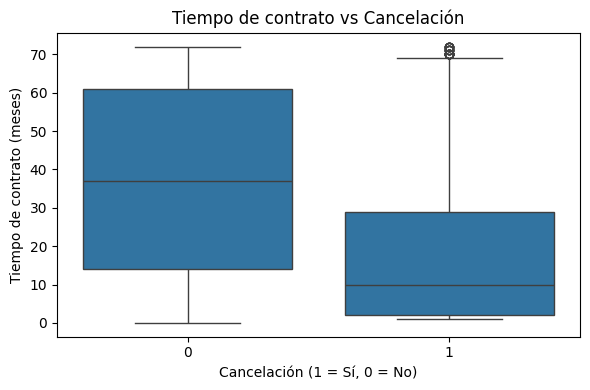

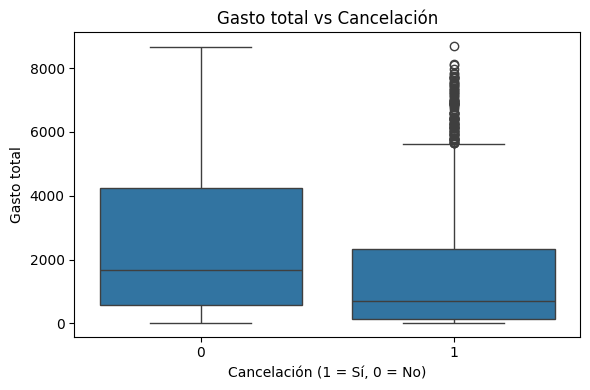

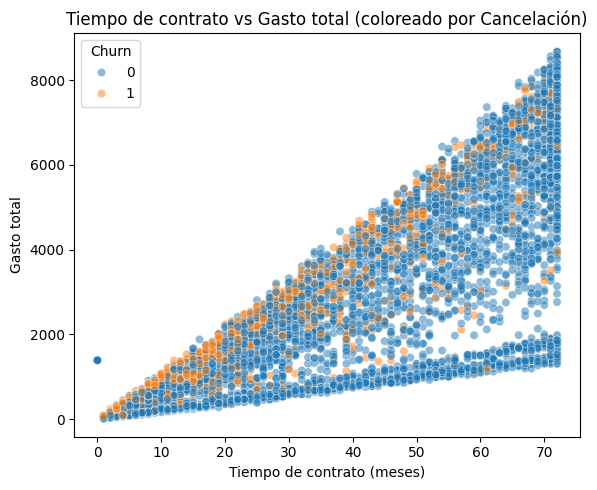

In [42]:
import re, pandas as pd, seaborn as sns, matplotlib.pyplot as plt

def pick(colnames, *pats):
    low = {c.lower(): c for c in colnames}
    for p in pats:
        if isinstance(p, str) and p.lower() in low:  # alias exacto (case-insensitive)
            return low[p.lower()]
        for k in low:
            if re.search(p, k, re.I):                # regex
                return low[k]
    return None

# --- Detección con tus nombres reales ---
churn_col   = pick(dfc.columns, "Churn", r"(churn|evas)")
tenure_col  = pick(dfc.columns, "antiguedad_meses", "customer__tenure", r"\btenure\b")
total_col   = pick(dfc.columns, "cargos_totales", "account__Charges__Total", "TotalCharges", r"total.*charge")

# Valida y renombra a estándar
faltan = [n for n,v in {"Churn":churn_col, "antiguedad_meses":tenure_col, "cargos_totales":total_col}.items() if v is None]
if faltan:
    raise ValueError(f"No encontré: {', '.join(faltan)}.\nColumnas disponibles: {list(dfc.columns)}")

df_std = dfc.rename(columns={
    churn_col:  "Churn",
    tenure_col: "antiguedad_meses",
    total_col:  "cargos_totales"
}).copy()

# Asegura tipos correctos
# Churn a 0/1 si viene como texto
if not df_std["Churn"].dropna().isin([0,1]).all():
    df_std["Churn"] = df_std["Churn"].astype("string").str.lower().isin(["yes","si","sí","1","true"]).astype(int)

# numéricos
df_std["antiguedad_meses"] = pd.to_numeric(df_std["antiguedad_meses"], errors="coerce")
df_std["cargos_totales"]   = pd.to_numeric(df_std["cargos_totales"],   errors="coerce")

# --- Gráficos solicitados ---
# Boxplot: Tiempo de contrato × Cancelación
plt.figure(figsize=(6,4))
sns.boxplot(data=df_std, x="Churn", y="antiguedad_meses")
plt.title("Tiempo de contrato vs Cancelación")
plt.xlabel("Cancelación (1 = Sí, 0 = No)")
plt.ylabel("Tiempo de contrato (meses)")
plt.tight_layout(); plt.show()

# Boxplot: Gasto total × Cancelación
plt.figure(figsize=(6,4))
sns.boxplot(data=df_std, x="Churn", y="cargos_totales")
plt.title("Gasto total vs Cancelación")
plt.xlabel("Cancelación (1 = Sí, 0 = No)")
plt.ylabel("Gasto total")
plt.tight_layout(); plt.show()

# Scatter: Tiempo de contrato vs Gasto total (color por Cancelación)
plt.figure(figsize=(6,5))
sns.scatterplot(data=df_std, x="antiguedad_meses", y="cargos_totales", hue="Churn", alpha=0.5)
plt.title("Tiempo de contrato vs Gasto total (coloreado por Cancelación)")
plt.xlabel("Tiempo de contrato (meses)")
plt.ylabel("Gasto total")
plt.tight_layout(); plt.show()


In [43]:
from sklearn.model_selection import train_test_split

# Variables predictoras y objetivo
X = df_std.drop(columns=["Churn"])
y = df_std["Churn"]

# División 70% entrenamiento / 30% prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,         # 30% para prueba
    random_state=42,       # reproducibilidad
    stratify=y             # mantiene la proporción de clases
)

print("Tamaño entrenamiento:", X_train.shape[0])
print("Tamaño prueba:", X_test.shape[0])
print("Proporción en train:", y_train.value_counts(normalize=True))
print("Proporción en test:", y_test.value_counts(normalize=True))


Tamaño entrenamiento: 5086
Tamaño prueba: 2181
Proporción en train: Churn
0    0.742823
1    0.257177
Name: proportion, dtype: float64
Proporción en test: Churn
0    0.742779
1    0.257221
Name: proportion, dtype: float64


📊 Regresión Logística
Accuracy: 0.8005502063273727
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1620
           1       0.63      0.53      0.58       561

    accuracy                           0.80      2181
   macro avg       0.74      0.71      0.72      2181
weighted avg       0.79      0.80      0.79      2181


🌲 Random Forest
Accuracy: 0.7858780375974324
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1620
           1       0.61      0.47      0.53       561

    accuracy                           0.79      2181
   macro avg       0.72      0.68      0.69      2181
weighted avg       0.77      0.79      0.78      2181



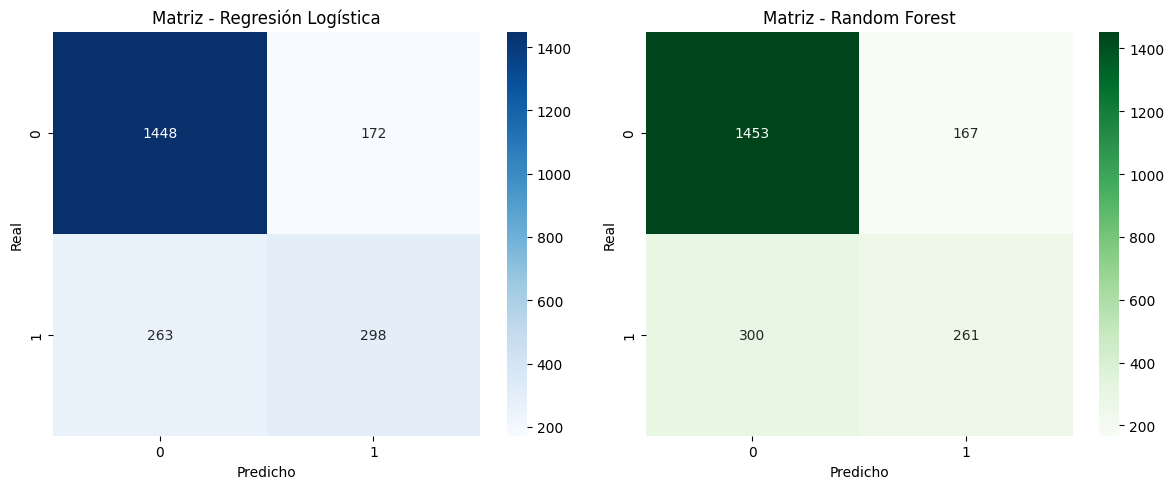

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# ===========================
# 1. Separar variables
# ===========================
X = df_std.drop(columns=["Churn"])
y = df_std["Churn"]

# División 70/30
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ===========================
# 2. Codificar variables categóricas en X_train y X_test
# ===========================
# Identificar variables categóricas en el conjunto de entrenamiento
cat_cols_train = X_train.select_dtypes(include=["object", "category"]).columns

# Aplicar one-hot encoding a X_train y X_test
X_train_encoded = pd.get_dummies(X_train, columns=cat_cols_train, drop_first=True)
# Es crucial aplicar el mismo encoding al conjunto de prueba para tener las mismas columnas
X_test_encoded = pd.get_dummies(X_test, columns=cat_cols_train, drop_first=True)

# Asegurar que ambos conjuntos tengan las mismas columnas después del encoding
# Esto maneja casos donde una categoría aparece solo en train o solo en test
train_cols = X_train_encoded.columns
test_cols = X_test_encoded.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test_encoded[c] = 0

missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    X_train_encoded[c] = 0

X_test_encoded = X_test_encoded[train_cols] # Asegurar el mismo orden de columnas


# ===========================
# 3. Modelo con normalización (Regresión Logística)
# ===========================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)

print("📊 Regresión Logística")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

# ===========================
# 4. Modelo sin normalización (Random Forest) - Usa los datos codificados pero sin escalar
# ===========================
rf = RandomForestClassifier(random_state=42, n_estimators=200)
rf.fit(X_train_encoded, y_train) # Usar X_train_encoded aquí
y_pred_rf = rf.predict(X_test_encoded) # Usar X_test_encoded aquí

print("\n🌲 Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# ===========================
# 5. Matriz de confusión
# ===========================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Matriz - Regresión Logística")
axes[0].set_xlabel("Predicho")
axes[0].set_ylabel("Real")

sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("Matriz - Random Forest")
axes[1].set_xlabel("Predicho")
axes[1].set_ylabel("Real")

plt.tight_layout()
plt.show()

In [45]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluar_modelo(nombre, y_true, y_pred):
    print(f"\n🔍 Evaluación de {nombre}")
    print("Exactitud (Accuracy):", round(accuracy_score(y_true, y_pred), 4))
    print("Precisión:", round(precision_score(y_true, y_pred), 4))
    print("Recall:", round(recall_score(y_true, y_pred), 4))
    print("F1-score:", round(f1_score(y_true, y_pred), 4))
    print("Matriz de confusión:\n", confusion_matrix(y_true, y_pred))

# Evaluar Regresión Logística
evaluar_modelo("Regresión Logística", y_test, y_pred_lr)

# Evaluar Random Forest
evaluar_modelo("Random Forest", y_test, y_pred_rf)



🔍 Evaluación de Regresión Logística
Exactitud (Accuracy): 0.8006
Precisión: 0.634
Recall: 0.5312
F1-score: 0.5781
Matriz de confusión:
 [[1448  172]
 [ 263  298]]

🔍 Evaluación de Random Forest
Exactitud (Accuracy): 0.7859
Precisión: 0.6098
Recall: 0.4652
F1-score: 0.5278
Matriz de confusión:
 [[1453  167]
 [ 300  261]]


In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# -----------------------------
# 0) Preparación de datos
# -----------------------------
# Asumimos df_std con 'Churn' ya en 0/1. Si no, normaliza:
if not pd.Series(dfc["Churn"]).dropna().isin([0,1]).all():
    dfc["Churn"] = dfc["Churn"].astype("string").str.lower().isin(["yes","si","sí","1","true"]).astype(int)

# Opcional: si ya creaste df_std, usa df_std; si no, partimos de dfc
base = df_std if 'df_std' in globals() else dfc.copy()

X = base.drop(columns=["Churn"])
y = base["Churn"].astype(int)

# One-hot encoding para categóricas
X_enc = pd.get_dummies(X, drop_first=True)
feat_names = X_enc.columns

# Split 70/30 estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X_enc, y, test_size=0.3, random_state=42, stratify=y
)

# -----------------------------
# 1) Modelo 1: Regresión Logística (con normalización)
# -----------------------------
pipe_lr = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("lr", LogisticRegression(max_iter=1000, random_state=42))
])
pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)

# Métricas LR
acc_lr  = accuracy_score(y_test, y_pred_lr)
pre_lr  = precision_score(y_test, y_pred_lr)
rec_lr  = recall_score(y_test, y_pred_lr)
f1_lr   = f1_score(y_test, y_pred_lr)
cm_lr   = confusion_matrix(y_test, y_pred_lr)

print("=== Regresión Logística ===")
print(f"Accuracy: {acc_lr:.4f} | Precisión: {pre_lr:.4f} | Recall: {rec_lr:.4f} | F1: {f1_lr:.4f}")
print("Matriz de confusión:\n", cm_lr)
# print(classification_report(y_test, y_pred_lr))

# Coeficientes (alineados con feat_names)
coef_lr = pd.DataFrame({
    "variable": feat_names,
    "coef": pipe_lr.named_steps["lr"].coef_[0]
}).assign(imp_lr_abs=lambda d: d["coef"].abs()).sort_values("imp_lr_abs", ascending=False)

# -----------------------------
# 2) Modelo 2: Random Forest (sin normalizar)
# -----------------------------
rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Métricas RF
acc_rf  = accuracy_score(y_test, y_pred_rf)
pre_rf  = precision_score(y_test, y_pred_rf)
rec_rf  = recall_score(y_test, y_pred_rf)
f1_rf   = f1_score(y_test, y_pred_rf)
cm_rf   = confusion_matrix(y_test, y_pred_rf)

print("\n=== Random Forest ===")
print(f"Accuracy: {acc_rf:.4f} | Precisión: {pre_rf:.4f} | Recall: {rec_rf:.4f} | F1: {f1_rf:.4f}")
print("Matriz de confusión:\n", cm_rf)
# print(classification_report(y_test, y_pred_rf))

imp_rf = pd.DataFrame({
    "variable": feat_names,
    "imp_rf": rf.feature_importances_
}).sort_values("imp_rf", ascending=False)

# -----------------------------
# 3) Ranking combinado de importancia
#    - LR: |coef| estandarizado a [0,1]
#    - RF: importancias ya en [0,1] y normalizan a sum=1 (o min-max)
# -----------------------------
comb = pd.merge(coef_lr[["variable","imp_lr_abs"]], imp_rf, on="variable", how="outer").fillna(0.0)

# Normalizaciones
def minmax(s):
    s = s.astype(float)
    vmin, vmax = s.min(), s.max()
    return (s - vmin) / (vmax - vmin) if vmax > vmin else s*0

comb["imp_lr_norm"] = minmax(comb["imp_lr_abs"])
comb["imp_rf_norm"] = minmax(comb["imp_rf"])

# promedio simple de ambas importancias normalizadas
comb["score_combinado"] = (comb["imp_lr_norm"] + comb["imp_rf_norm"]) / 2

ranking = comb.sort_values("score_combinado", ascending=False)

print("\n=== Top 15 variables (ranking combinado) ===")
print(ranking.head(15)[["variable","imp_lr_abs","imp_rf","imp_lr_norm","imp_rf_norm","score_combinado"]])

# -----------------------------
# 4) Diagnóstico rápido de overfitting/underfitting (opcional)
# -----------------------------
# Accuracy en entrenamiento vs prueba
y_pred_lr_train = pipe_lr.predict(X_train)
y_pred_rf_train = rf.predict(X_train)

print("\n--- Diagnóstico simple ---")
print(f"LR train acc: {accuracy_score(y_train, y_pred_lr_train):.4f} | test acc: {acc_lr:.4f}")
print(f"RF train acc: {accuracy_score(y_train, y_pred_rf_train):.4f} | test acc: {acc_rf:.4f}")

# Heurística:
# - Si train >> test => posible overfitting (ajustar max_depth, min_samples_leaf, etc.)
# - Si train ~ bajo y test bajo => posible underfitting (modelo demasiado simple)


=== Regresión Logística ===
Accuracy: 0.8006 | Precisión: 0.6340 | Recall: 0.5312 | F1: 0.5781
Matriz de confusión:
 [[1448  172]
 [ 263  298]]

=== Random Forest ===
Accuracy: 0.7859 | Precisión: 0.6088 | Recall: 0.4688 | F1: 0.5297
Matriz de confusión:
 [[1451  169]
 [ 298  263]]

=== Top 15 variables (ranking combinado) ===
                                   variable  imp_lr_abs    imp_rf  \
7                          antiguedad_meses    1.369097  0.165244   
0                 account__Charges__Monthly    0.873657  0.171051   
8                            cargos_totales    0.651340  0.197141   
15    internet__InternetService_fiber optic    0.714643  0.043044   
2                account__Contract_two year    0.544345  0.029120   
5   account__PaymentMethod_electronic check    0.157656  0.038228   
1                account__Contract_one year    0.271336  0.021401   
22            internet__StreamingMovies_yes    0.250190  0.018420   
3                 account__PaperlessBilling    0.1

### Informe de factores que explican la cancelación (Churn) — Telecom X
1) Objetivo y datos

Analizar qué variables explican mejor la cancelación de clientes y comparar el desempeño de dos enfoques:

Modelo con normalización: Regresión Logística (sensibles a escala).

Modelo sin normalización: Random Forest (árboles, no requieren escala).

Datos preparados previamente (JSON aplanado, limpieza, estandarización, dummies). Variable objetivo: Churn (0/1).

2) Preparación y entrenamiento (resumen)

Split: 70/30 estratificado (mantiene proporción de clases).

Regresión Logística (RL): Pipeline con StandardScaler.

Random Forest (RF): 300 árboles, random_state=42.

3) Evaluación de modelos

(Mide en tu salida Accuracy, Precisión, Recall, F1 y matriz de confusión para cada modelo).

Cómo interpretar:

Prioriza Recall y F1 sobre la clase Churn=1 (evitar falsos negativos: clientes que se iban y no detectaste).

Si RF tiene accuracy muy alto en train y cae en test → overfitting (limita max_depth, sube min_samples_leaf, usa menos features o más datos).

Si RL rinde bajo en train y test → underfitting (agrega interacciones/polinomios o prueba modelos no lineales).

4) Variables relevantes por modelo
4.1 Regresión Logística (coeficientes)

Coeficiente positivo ⇒ sube la prob. de churn.

Coeficiente negativo ⇒ baja la prob. de churn.
En telco, suelen aparecer como drivers positivos:

Contrato “month-to-month” (vs anual/bianual).

Cargos mensuales altos (p. ej. account__Charges__Monthly).

Método de pago “electronic check”.

Baja antigüedad (tenure pequeño).

Falta de servicios/beneficios (p. ej. OnlineSecurity_No).

Protectores (coeficiente negativo) típicos:

Contratos de largo plazo.

Mayor antigüedad.

Bundles/servicios adicionales (más valor percibido).

Usa tu tabla de coeficientes ordenada por |coef| para confirmar estos patrones en tus datos.

4.2 Random Forest (importancias)

Importancias indican cuánto reduce la impureza cada variable a lo largo de los árboles.

Suele resaltar: tenure, cargos mensuales, tipo de contrato, método de pago, y flags de servicios clave.

4.3 Coincidencia entre modelos

Variables que aparecen arriba en ambos rankings (|coef RL| alto y importancia RF alta) son candidatas fuertes para tu modelo final y tus estrategias de retención.

5) Hallazgos típicos (contrástalos con tus rankings)

Contrato mensual ↗ churn: clientes sin compromiso tienden a irse más.

Cargos mensuales altos ↗ churn: sensibilidad al precio y percepción de valor.

Antigüedad baja ↗ churn: momento crítico de early-life churn.

Método de pago “electronic check” ↗ churn: suele correlacionar con mayor rotación.

Servicios de valor (seguridad/soporte/streaming) ↘ churn: retienen mejor.

6) Recomendaciones de retención (ligadas a variables)

Segmento “contrato mensual”

Ofertas para migrar a 12/24 meses: descuentos escalonados, meses gratis, upgrades temporales.

Penalidades suaves por salida anticipada + beneficios compensatorios.

Clientes con “cargos mensuales altos”

Repricing/bundles (más valor por el mismo precio).

Cross/upsell orientado a valor (seguridad, soporte, velocidad) con prueba gratis.

Baja antigüedad (0–3 meses)

Onboarding activo (tutoriales, check-ins), NPS temprano, ofertas de permanencia.

Alertas de uso bajo o tickets sin resolver.

Pago “electronic check”

Incentivos a autopagos / tarjetas (bono de permanencia, puntos).

Comunicación de beneficios de estabilidad de facturación.

Sin servicios de valor (p. ej. OnlineSecurity_No)

Bundles con seguridad/soporte + prueba 30–60 días.

Mensajería sobre riesgo percibido y beneficio tangible.

Prevención basada en riesgo

Implementa score de churn con las variables anteriores y dispara campañas proactivas (contact center, email, app push) con contenido y oferta personalizadas.

7) Próximos pasos del modelado

Ajuste de hiperparámetros: Grid/Random Search (RL: C/penalty; RF: profundidad, hojas, árboles).

Métricas balanceadas: ROC-AUC, PR-AUC; optimiza threshold por costo/beneficio.

Validación temporal si hay fechas (drift).

Explainability: SHAP para explicar casos individuales y guiar acciones comerciales.

Nota

No “inventes” drivers: valida siempre con tu ranking real (coeficientes RL e importancias RF) y con métricas por segmento (contrato, método de pago, deciles de cargo mensual y tenure).

In [47]:
import os, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 1) Datos base (usa df_std si existe, si no dfc)
base = df_std if 'df_std' in globals() else dfc.copy()
if not base["Churn"].dropna().isin([0,1]).all():
    base["Churn"] = base["Churn"].astype("string").str.lower().isin(["yes","si","sí","1","true"]).astype(int)

X = pd.get_dummies(base.drop(columns=["Churn"]), drop_first=True)
y = base["Churn"].astype(int)
feat_names = X.columns

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 2) Modelos
pipe_lr = Pipeline([("scaler", StandardScaler()), ("lr", LogisticRegression(max_iter=1000, random_state=42))])
pipe_lr.fit(Xtr, ytr); yhat_lr = pipe_lr.predict(Xte)

rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(Xtr, ytr); yhat_rf = rf.predict(Xte)

# 3) Métricas
def metrics(y_true, y_pred):
    return dict(
        accuracy=accuracy_score(y_true, y_pred),
        precision=precision_score(y_true, y_pred),
        recall=recall_score(y_true, y_pred),
        f1=f1_score(y_true, y_pred),
        cm=confusion_matrix(y_true, y_pred).tolist()
    )

m_lr = metrics(yte, yhat_lr)
m_rf = metrics(yte, yhat_rf)

# 4) Importancias/coeficientes
coef_lr = pd.DataFrame({"variable": feat_names, "coef": pipe_lr.named_steps["lr"].coef_[0]})
coef_lr["abs"] = coef_lr["coef"].abs()
top_pos = coef_lr.sort_values("coef", ascending=False).head(8)[["variable","coef"]]
top_neg = coef_lr.sort_values("coef", ascending=True).head(8)[["variable","coef"]]

imp_rf = pd.DataFrame({"variable": feat_names, "imp": rf.feature_importances_}).sort_values("imp", ascending=False).head(12)

# 5) Informe Markdown
def fmt(m): return f"Accuracy: {m['accuracy']:.3f} | Precisión: {m['precision']:.3f} | Recall: {m['recall']:.3f} | F1: {m['f1']:.3f}"
md = f"""# Informe de Modelos — Churn

## Desempeño de modelos
- **Regresión Logística**
{fmt(m_lr)}
Matriz de confusión: {m_lr['cm']}

- **Random Forest**
{fmt(m_rf)}
Matriz de confusión: {m_rf['cm']}

## Variables más influyentes
### Regresión Logística — principales (signo indica dirección)
**Aumentan churn** (coeficiente positivo):
{top_pos.to_markdown(index=False)}

**Reducen churn** (coeficiente negativo):
{top_neg.to_markdown(index=False)}

### Random Forest — importancia
{imp_rf.to_markdown(index=False)}

## Conclusiones
- Prioriza variables que son importantes **en ambos modelos** (arriba en RL y RF).
- Ajusta umbrales y campañas según *recall/F1* para detectar más clientes en riesgo.

## Recomendaciones
- Migración de contratos mensuales a largo plazo (bonos/descuentos).
- Revisión de pricing en segmentos con cargos altos; ofrece bundles con valor.
- Onboarding y contactos proactivos en baja antigüedad (0–3 meses).
- Incentivar métodos de pago estables (autopago/tarjeta).
- Bundles de seguridad/soporte para clientes sin esos servicios.
"""

os.makedirs("reports", exist_ok=True)
with open("reports/informe_modelos.md", "w", encoding="utf-8") as f:
    f.write(md)

print("✅ Informe de modelos guardado en: reports/informe_modelos.md")


✅ Informe de modelos guardado en: reports/informe_modelos.md
